In [65]:
import numpy as np
import keras
import pickle
import zarr
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.regularizers import l2
from keras.callbacks import Callback

class RL_Datapoint():
    def __init__(self, state, policy, values):
        self.state = state
        self.policy = policy
        self.values = values
        
def __read_file_data(ID, path='dataset/'):
    dataset = zarr.group(store=zarr.ZipStore(path + str(ID) +'.zip', mode="r"))
    X = np.array(dataset['states'])
    policies = np.array(dataset['policies'])
    values = np.array(dataset['values'])
    return X,policies,values

def generator(batch_size, datasetFileLength, path='dataset/'):
    while True:
        files_sequence = list(range(datasetFileLength))
        np.random.shuffle(files_sequence)

        for file_step, file_id in enumerate(files_sequence): 
            X, policies, values = __read_file_data(file_id,path)
#             X = np.rollaxis(X, 1,4).shape
            rand_indices = np.arange(len(X))
            np.random.shuffle(rand_indices)

            for i in range(int(len(X)/batch_size)):
                batch_indices = rand_indices[i*batch_size: (i+1)*batch_size]
                yield X[batch_indices],[policies[batch_indices],values[batch_indices]]
                
def plotHistory( history):
    import matplotlib.pyplot as plt

    val_loss = history.history['val_loss']
    val_policy_loss = history.history['val_policy_loss']
    val_value_loss = history.history['val_value_loss']
    loss = history.history['loss']
    policy_loss = history.history['policy_loss']
    value_loss = history.history['value_loss']
    
    epochs = range(1,len(loss) + 1)

    # fig, ax = plt.subplots(nrows=2, ncols=2)
    fig = plt.figure()

    plt.subplot(2, 2, 1)
    plt.plot(epochs,loss,'bo',label='loss')
    plt.plot(epochs,val_loss,'b',label='val_loss')
    plt.title = 'Training and validation loss'
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs,policy_loss,'bo',label='policy_loss')
    plt.plot(epochs,val_policy_loss,'b',label='val_policy_loss')
    plt.title = 'Training and validation policy loss'
    plt.legend()        

    plt.subplot(2, 2, 3)
    plt.plot(epochs,value_loss,'bo',label='value_loss')
    plt.plot(epochs,val_value_loss,'b',label='val_value_loss')
    plt.title = 'Training and validation value loss'
    plt.legend()
    plt.show()

### Our Model based 

In [16]:
def getResidualNetwork(input_shape, output_value=1, output_policy=2272):
    
    channel_pos = 'channels_first'
    inp_shape = Input(input_shape,name='input1')
    x = Conv2D(256, kernel_size=(3,3), padding = 'same', input_shape=input_shape,data_format=channel_pos,name='conv2d_Prep')(inp_shape)
    x = BatchNormalization(axis=1,name='batch_normalization_prep')(x)
    x_a1 = Activation('relu',name='activation_prep')(x)
    activated_x = x_a1
    
#     activated_x, x
    def createResidualBlock(block_nr, activated_x):
        nr = block_nr *2 -1
        x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_'+str(nr), padding='same',data_format=channel_pos)(activated_x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr))(x)
        x = Activation('relu',name = 'activation_'+str(nr))(x)
        x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_'+str(nr+1),padding = 'same',data_format=channel_pos)(x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr+1))(x)
        x = keras.layers.add([x,activated_x],name='add_' + str(block_nr))
        activated_x = Activation('relu',name='activation_'+str(nr+1))(x)
        return activated_x
    
    # build eight residual blocks
    for i in range (1,8):
        activated_x = createResidualBlock(i, activated_x)
        

    
    # Value header
    x = Conv2D(32, kernel_size=(1,1),name='value_conv2d', kernel_regularizer=l2(1e-4), padding = 'same',data_format=channel_pos)(activated_x)
    xb = BatchNormalization(axis=1,name='value_batch_normalization')(x)
    xA = Activation('relu',name='value_activation')(xb)
    xF = Flatten(name='value_flatten')(xA)
    dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(1e-4),name='value_dense')(xF)
    value = Dense(output_value, activation='tanh', kernel_regularizer=l2(1e-4), name='value')(dense_1)

#     # Policy Header
#     xConv = Conv2D(8, kernel_size=(7,7), padding = 'same',name='policy_conv2d',data_format=channel_pos)(activated_x)
#     xb = BatchNormalization(axis=1,name='policy_batch_normalization')(xConv)
#     xA = Activation('relu',name='policy_activation')(xb)
#     xF = Flatten(name='policy_flatten')(xA)
#     policy = Dense(output_policy, activation='softmax', name='policy')(xF)


    from keras.models import Model
    model = Model(inp_shape, [value])

    model.summary()
    return model


### Model of https://github.com/Zeta36/chess-alpha-zero

In [52]:
def _build_residual_block( x, index):
	in_x = x
	res_name = "res"+str(index)
	x = Conv2D(filters=256, kernel_size=3, padding="same",
			   data_format="channels_first", use_bias=False, kernel_regularizer=l2(1e-4), 
			   name=res_name+"_conv1-"+str(3)+"-"+str(256))(x)
	x = BatchNormalization(axis=-1, name=res_name+"_batchnorm1")(x)
	x = Activation("relu",name=res_name+"_relu1")(x)
	x = Conv2D(filters=256, kernel_size=3, padding="same",
			   data_format="channels_first", use_bias=False, kernel_regularizer=l2(1e-4), 
			   name=res_name+"_conv2-"+str(3)+"-"+str(256))(x)
	x = BatchNormalization(axis=-1, name="res"+str(index)+"_batchnorm2")(x)
	x = Add(name=res_name+"_add")([in_x, x])
	x = Activation("relu", name=res_name+"_relu2")(x)
	return x

def build():
	"""
	Builds the full Keras model and stores it in self.model.
	"""
	in_x = x = Input(inp_shape)

	# (batch, channels, height, width)
	x = Conv2D(filters=256, kernel_size=5, padding="same",
			   data_format="channels_first", use_bias=False, kernel_regularizer=l2(1e-4),
			   name="input_conv-"+str(5)+"-"+str(256))(x)
	x = BatchNormalization(axis=-1,
	name="input_batchnorm")(x)
	x = Activation("relu", name="input_relu")(x)

	for i in range(7):
		x = _build_residual_block(x, i + 1)

	res_out = x
	
	# for policy output
	x = Conv2D(filters=2, kernel_size=1, data_format="channels_first", use_bias=False, kernel_regularizer=l2(1e-4),
				name="policy_conv-1-2")(res_out)
	x = BatchNormalization(axis=-1, name="policy_batchnorm")(x)
	x = Activation("relu", name="policy_relu")(x)
	x = Flatten(name="policy_flatten")(x)
	# no output for 'pass'
	policy_out = Dense(CLASSES_LEN, kernel_regularizer=l2(1e-4), activation="softmax", name="policy")(x)

	# for value output
	x = Conv2D(filters=4, kernel_size=1, data_format="channels_first", use_bias=False, kernel_regularizer=l2(1e-4),
				name="value_conv-1-4")(res_out)
	x = BatchNormalization(axis=-1, name="value_batchnorm")(x)
	x = Activation("relu",name="value_relu")(x)
	x = Flatten(name="value_flatten")(x)
	x = Dense(256, kernel_regularizer=l2(1e-4), activation="relu", name="value_dense")(x)
	value_out = Dense(1, kernel_regularizer=l2(1e-4), activation="tanh", name="value")(x)

	return Model(in_x, [policy_out, value_out], name="chess_model")

model=build()

<h3>NN Architecture: ResNet</h3>

<h3>Main Parameters of the NN</h3>

In [53]:
# ----------- parameters ----------------
files_len = 1000                                # amount of zip files
file_ids = np.arange(files_len)               
# np.random.shuffle(file_ids)
train_ids = file_ids[:int(len(file_ids)*0.9)] # file_ids for training set
val_ids = file_ids[int(len(file_ids)*0.9):]   # file_ids for validation set 
filepath="models/model-{epoch:02d}.hdf5"      # path to save model
zip_length = 10000                            # amount of datapoints in a zip file
data_len = files_len * zip_length             # whole amount of datapoints in all zip files
batch_size = 256                              # batch size
steps_per_epoch = int((len(train_ids)*zip_length)/batch_size) # amount of batches in one epoch
CLASSES_LEN = 2272                            # amount of classes for policy
channel_pos = 'channels_last'          
dataset_path = 'dataCorrected/train/'                     # relative directory to the dataset
inp_shape = (60,8,8)                          # shape of a datapoint
val_id = files_len -1 
x_val, policies_val, values_val = __read_file_data(val_id,path=dataset_path)
print('train_ids:',np.min(train_ids),' - ', np.max(train_ids))
print('val_ids:',np.min(val_ids),' - ', np.max(val_ids))
print('x_val:', x_val.shape)

train_ids: 0  -  899
val_ids: 900  -  999
x_val: (10000, 60, 8, 8)


<h3>Build the model</h3>

In [54]:
model = build()#getResidualNetwork(inp_shape, output_policy=CLASSES_LEN)
sgd = optimizers.SGD(lr=0.000, momentum=0.9, decay=0.0, nesterov=False)

def acc_reg(y_true,y_pred):
    return K.constant(1) - K.square(K.mean((y_pred-y_true), axis=1))

def acc_round(y_true,y_pred):
    return K.mean(K.equal(K.round(y_true),K.round(y_pred)), axis=-1)
policy_weight = K.variable(0.8)
value_weight = K.variable(0.2)

model.compile(loss={'policy':'categorical_crossentropy',
                    'value':'mean_squared_error'}, optimizer=sgd,
              metrics={'policy':'accuracy', 'value':acc_round}, loss_weights=[policy_weight, value_weight])

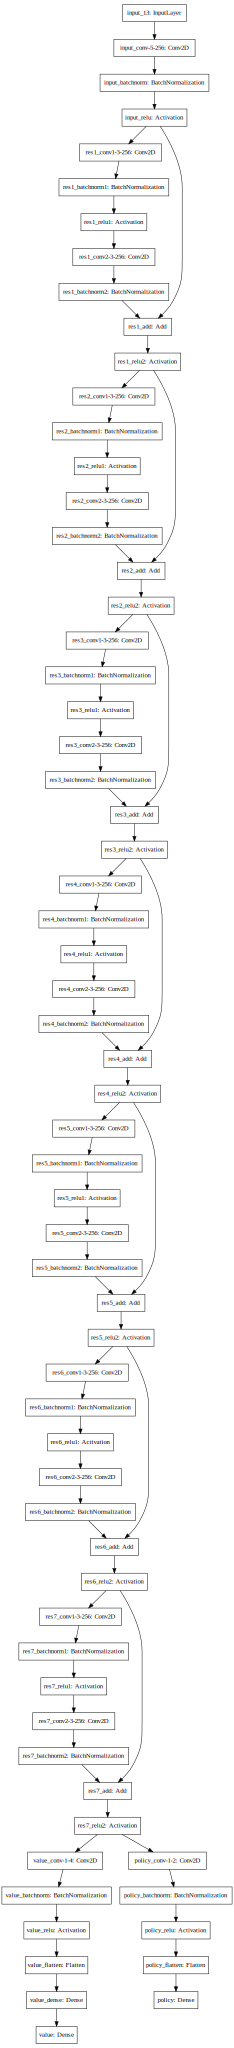

In [55]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)

<h3>Define callbacks</h3>

In [36]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids)//10,path=dataset_path), 
                              steps_per_epoch=int((len(train_ids)/10*zip_length)/batch_size), 
                              callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [values_val]))


Epoch 1/5
351/351 [==============================] - 64s 183ms/step - loss: 0.9204 - acc_round: 0.0148 - val_loss: 0.9026 - val_acc_round: 0.0161

Epoch 00001: val_loss did not improve from 0.83524
Epoch:  1  - lr: 5.8525347e-05  - batch: 0  - epoch:  1
Epoch 2/5
351/351 [==============================] - 63s 179ms/step - loss: 0.8789 - acc_round: 0.0088 - val_loss: 0.8570 - val_acc_round: 0.0115

Epoch 00002: val_loss did not improve from 0.83524
Epoch:  2  - lr: 0.000109139786  - batch: 1  - epoch:  2
Epoch 3/5
351/351 [==============================] - 65s 185ms/step - loss: 0.8471 - acc_round: 0.0085 - val_loss: 0.8383 - val_acc_round: 0.0115

Epoch 00003: val_loss did not improve from 0.83524
Epoch:  3  - lr: 0.00017204302  - batch: 2  - epoch:  3
Epoch 4/5
351/351 [==============================] - 64s 181ms/step - loss: 0.8387 - acc_round: 0.0085 - val_loss: 0.8354 - val_acc_round: 0.0115

Epoch 00004: val_loss did not improve from 0.83524
Epoch:  4  - lr: 0.00023494623  - batch

<h4>Callback for checkpoint and tensorboard</h4>

In [56]:
# callbacks 
from datetime import datetime
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
logdir="logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

#### Callback for loss weights

In [57]:
class LossWeightCallback(Callback):
    def __init__(self, policy_weight, value_weight):
        self.policy_weight = policy_weight
        self.value_weight = value_weight
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        self.policy_weight = self.policy_weight - 0.05
        self.value_weight = self.value_weight + 0.05

<h4>Callback for Learning rate</h4>

In [58]:
# learning rate
from  LearningRateScheduler import *
epochs = 5
batch_len = epochs * int(data_len/ (batch_size))
max_lr = 0.001*8
total_it = batch_len
min_lr = 0.0001
print('BatchLen: ', batch_len, ' - DataLen: ', data_len)
lr_schedule = OneCycleSchedule(start_lr=max_lr/8, max_lr=max_lr, cycle_length=total_it*.4, cooldown_length=total_it*.6, finish_lr=min_lr)
scheduler = LinearWarmUp(lr_schedule, start_lr=min_lr, length=total_it/30)
bt = BatchLearningRateScheduler(scheduler)

BatchLen:  195310  - DataLen:  10000000


In [59]:
callbacks_list = [checkpoint,tensorboard_callback,bt]
# callbacks_list = [checkpoint,bt]


In [60]:
from keras import backend
backend.set_image_dim_ordering('th')
print(backend.image_data_format())

channels_first


##### Model von https://github.com/Zeta36/chess-alpha-zero/blob/master/src/chess_zero/agent/model_chess.py mit 0.8* Policy + 0.2*Value Gewichtung

In [66]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), 
                              steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), 
                              callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/5
35156/35156 [==============================] - 7357s 209ms/step - loss: 3.5942 - policy_loss: 3.7947 - value_loss: 0.8013 - policy_acc: 0.3307 - value_acc_round: 0.0083 - val_loss: 2.5766 - val_policy_loss: 2.5682 - val_value_loss: 0.8100 - val_policy_acc: 0.4350 - val_value_acc_round: 0.0139

Epoch 00001: val_loss improved from inf to 2.57662, saving model to models/model-01.hdf5


TypeError: Not JSON Serializable: <tf.Variable 'Variable_6:0' shape=() dtype=float32_ref>

##### Model with 0.25 Policy + 0.75* Value -> Policy Accuracy ungefähr 60%, Value Accuracy ungefähr 18%

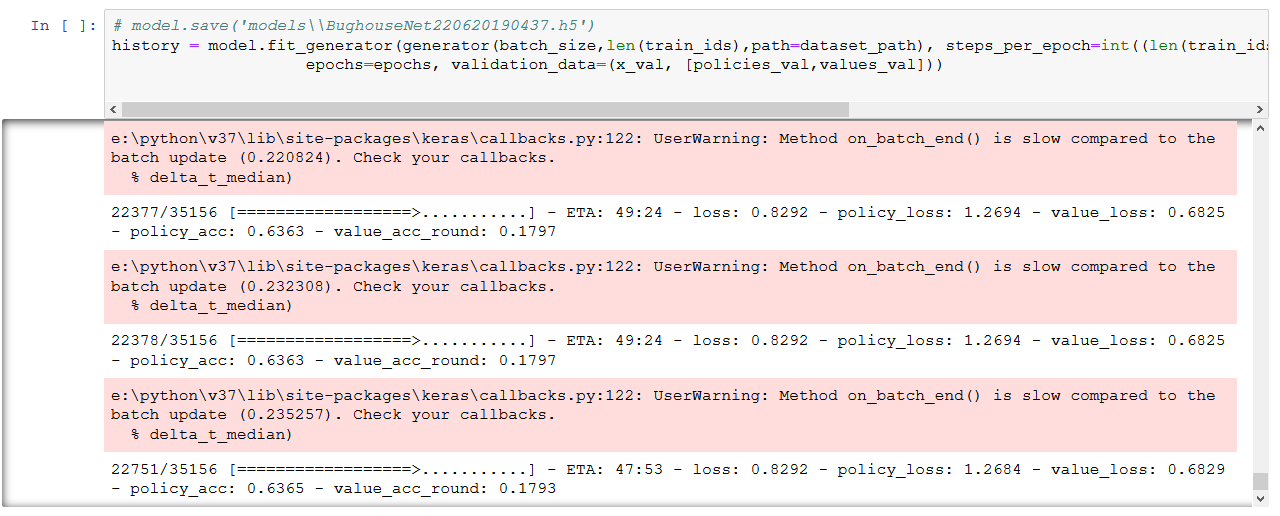

##### Model with Value Header Channel = 8


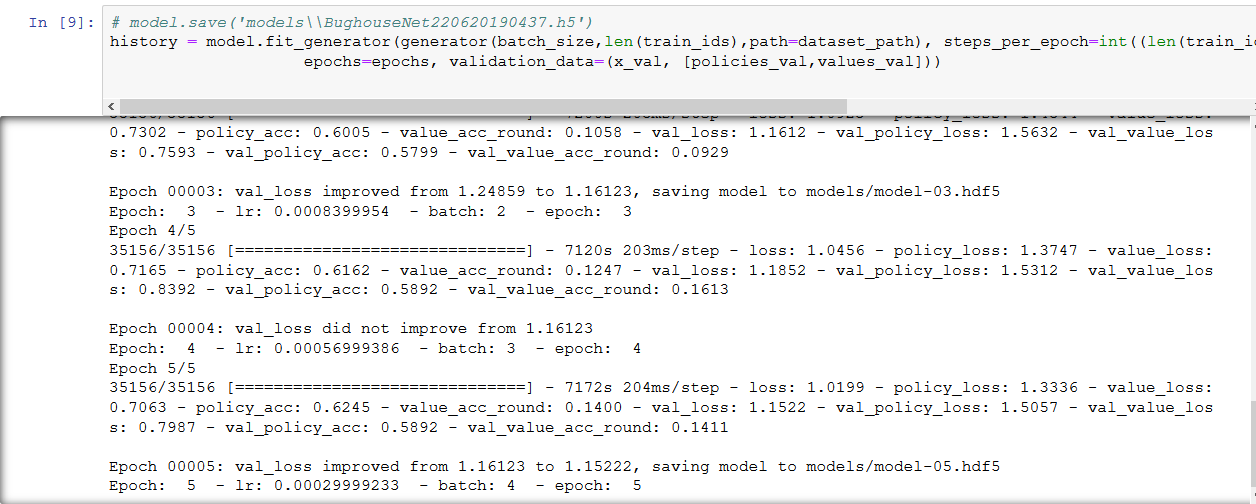

##### Model mit nur Value Output aber mit kleinem Datensatz mit Lernrate 0.0001 als minimum

In [36]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), 
                              steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), 
                              callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/5
351/351 [==============================] - 64s 183ms/step - loss: 0.9204 - acc_round: 0.0148 - val_loss: 0.9026 - val_acc_round: 0.0161

Epoch 00001: val_loss did not improve from 0.83524
Epoch:  1  - lr: 5.8525347e-05  - batch: 0  - epoch:  1
Epoch 2/5
351/351 [==============================] - 63s 179ms/step - loss: 0.8789 - acc_round: 0.0088 - val_loss: 0.8570 - val_acc_round: 0.0115

Epoch 00002: val_loss did not improve from 0.83524
Epoch:  2  - lr: 0.000109139786  - batch: 1  - epoch:  2
Epoch 3/5
351/351 [==============================] - 65s 185ms/step - loss: 0.8471 - acc_round: 0.0085 - val_loss: 0.8383 - val_acc_round: 0.0115

Epoch 00003: val_loss did not improve from 0.83524
Epoch:  3  - lr: 0.00017204302  - batch: 2  - epoch:  3
Epoch 4/5
351/351 [==============================] - 64s 181ms/step - loss: 0.8387 - acc_round: 0.0085 - val_loss: 0.8354 - val_acc_round: 0.0115

Epoch 00004: val_loss did not improve from 0.83524
Epoch:  4  - lr: 0.00023494623  - batch

##### Model mit nur Value Output aber mit kleinem Datensatz mit Lernrate 0.01 als minimum

In [32]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids)//10,path=dataset_path), 
                              steps_per_epoch=int((len(train_ids)/10*zip_length)/batch_size), 
                              callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [values_val]))


Epoch 1/5
351/351 [==============================] - 65s 184ms/step - loss: 0.8503 - acc_round: 0.0095 - val_loss: 0.8437 - val_acc_round: 0.0115

Epoch 00001: val_loss improved from 0.85584 to 0.84369, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.050412185  - batch: 0  - epoch:  1
Epoch 2/5
351/351 [==============================] - 63s 179ms/step - loss: 0.8484 - acc_round: 0.0092 - val_loss: 0.8424 - val_acc_round: 0.0115

Epoch 00002: val_loss improved from 0.84369 to 0.84238, saving model to models/model-02.hdf5
Epoch:  2  - lr: 0.05670251  - batch: 1  - epoch:  2
Epoch 3/5
351/351 [==============================] - 63s 180ms/step - loss: 0.8458 - acc_round: 0.0087 - val_loss: 0.8432 - val_acc_round: 0.0115

Epoch 00003: val_loss did not improve from 0.84238
Epoch:  3  - lr: 0.06299283  - batch: 2  - epoch:  3
Epoch 4/5
351/351 [==============================] - 63s 180ms/step - loss: 0.8429 - acc_round: 0.0097 - val_loss: 0.8388 - val_acc_round: 0.0115

Epoch 00004: va

<h3>MNist overfitting</h3>

In [23]:
def getResidualNetwork(input_shape):
    
    channel_pos = 'channels_first'
    inp_shape = Input(input_shape,name='input1')
    x = Conv2D(256, kernel_size=(3,3), padding = 'same', input_shape=input_shape,data_format=channel_pos,name='conv2d_1')(inp_shape)
    x = BatchNormalization(axis=1,name='batch_normalization_1')(x)
    x_a1 = Activation('relu',name='activation_1')(x)

    x = Conv2D(256, kernel_size=(3,3),name ='conv2d_2' ,padding = 'same',data_format=channel_pos)(x_a1)
    x = BatchNormalization(axis=1, name = 'batch_normalization_2')(x)
    x = Activation('relu',name = 'activation_2')(x)
    x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_3',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1, name = 'batch_normalization_3')(x)

    x = keras.layers.add([x,x_a1],name='add1')
    x_a2 = Activation('relu',name='activation_3')(x)
    x = Conv2D(256, kernel_size=(3,3),name = 'conv2d_4', padding = 'same',data_format=channel_pos)(x_a2)
    x = BatchNormalization(axis=1,name = 'batch_normalization_4')(x)
    x = Activation('relu',name='activation_4')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_5',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_5')(x)

    x = keras.layers.add([x,x_a2],name='add_2')
    x_a3 = Activation('relu',name='activation_5')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_6', padding = 'same',data_format=channel_pos)(x_a3)
    x = BatchNormalization(axis=1,name='batch_normalization_6')(x)
    x = Activation('relu',name='activation_6')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_7',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_7')(x)

    x = keras.layers.add([x,x_a3],name='add_3')
    x_a4 = Activation('relu',name='activation_7')(x)
    x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_8',padding = 'same',data_format=channel_pos)(x_a4)
    x = BatchNormalization(axis=1,name='batch_normalization_8')(x)
    x = Activation('relu',name='activation_8')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_9',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_9')(x)

    x = keras.layers.add([x,x_a4],name='add4')
    x_a5 = Activation('relu',name='activation_9')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_10', padding = 'same',data_format=channel_pos)(x_a5)
    x = BatchNormalization(axis=1,name='batch_normalization_10')(x)
    x = Activation('relu',name='activation_10')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_11', padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_11')(x)

    x = keras.layers.add([x,x_a5],name='add_5')
    x_a6 = Activation('relu',name='activation_11')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_12',padding = 'same',data_format=channel_pos)(x_a6)
    x = BatchNormalization(axis=1,name='batch_normalization_12')(x)
    x = Activation('relu',name='activation_12')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_13',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_13')(x)

    x = keras.layers.add([x,x_a6],name='add6')
    x_a7 = Activation('relu',name='activation_13')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_14',padding = 'same',data_format=channel_pos)(x_a7)
    x = BatchNormalization(axis=1,name='batch_normalization_14')(x)
    x = Activation('relu',name='activation_14')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_15',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_15')(x)

    x = keras.layers.add([x,x_a7],name='add_7')
    x_a8 = Activation('relu',name='activation_15')(x)
    x = Conv2D(1, kernel_size=(1,1),name='conv2d_17', padding = 'same',data_format=channel_pos)(x_a8)
    xb = BatchNormalization(axis=1,name='batch_normalization_17')(x)
    xConv = Conv2D(8, kernel_size=(7,7), padding = 'same',name='conv2d_16',data_format=channel_pos)(x_a8)
    xA = Activation('relu',name='activation_17')(xb)
    xb = BatchNormalization(axis=1,name='batch_normalization_16')(xConv)
    xF = Flatten(name='flatten_2')(xA)
    xA = Activation('relu',name='activation_16')(xb)

    dense_1 = Dense(256, activation='relu',name='dense_1')(xF)
    xF = Flatten(name='flatten_1')(xA)

    value = Dense(1, activation='tanh', name='value')(dense_1)
    policy = Dense(10, activation='softmax', name='policy')(xF)

    from keras.models import Model
    model = Model(inp_shape, [policy])

    model.summary()
    return model

In [17]:
from keras.datasets import mnist
img_rows, img_cols = 28, 28
num_classes = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
from  LearningRateScheduler import *
data_len = len(x_train)
epochs = 20
batch_len = epochs * int(data_len/ (batch_size))
max_lr = 0.001*8
total_it = batch_len
min_lr = 0.0001
print('BatchLen: ', batch_len, ' - DataLen: ', data_len)
lr_schedule = OneCycleSchedule(start_lr=max_lr/8, max_lr=max_lr, cycle_length=total_it*.4, cooldown_length=total_it*.6, finish_lr=min_lr)
scheduler = LinearWarmUp(lr_schedule, start_lr=min_lr, length=total_it/30)
bt = BatchLearningRateScheduler(scheduler)

BatchLen:  4680  - DataLen:  60000


In [20]:
model = getResidualNetwork(input_shape)
sgd = optimizers.SGD(lr=0.000, momentum=0.9, decay=0.0, nesterov=False)

def acc_reg(y_true,y_pred):
    return K.constant(1) - K.square(K.mean((y_pred-y_true), axis=1))
callbacks_list = [bt]

model.compile(loss=['categorical_crossentropy'], optimizer=sgd,
              metrics=['accuracy'])
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test),
#          callbacks=callbacks_list)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 28, 1)   64768       input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 28, 1)   1024        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 28, 1)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
  512/60000 [..............................] - ETA: 9:31 - loss: 2.5902 - acc: 0.0762 

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290199). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 59s 982us/step - loss: 1.3563 - acc: 0.6172 - val_loss: 0.8343 - val_acc: 0.8215
Epoch:  1  - lr: 0.001590812  - batch: 0  - epoch:  1
Epoch 2/20
60000/60000 [==============================] - 54s 901us/step - loss: 0.6064 - acc: 0.8796 - val_loss: 0.4587 - val_acc: 0.9088
Epoch:  2  - lr: 0.0033482907  - batch: 1  - epoch:  2
Epoch 3/20
60000/60000 [==============================] - 54s 903us/step - loss: 0.3410 - acc: 0.9342 - val_loss: 0.3061 - val_acc: 0.9347
Epoch:  3  - lr: 0.0051057693  - batch: 2  - epoch:  3
Epoch 4/20
60000/60000 [==============================] - 54s 902us/step - loss: 0.2215 - acc: 0.9587 - val_loss: 0.2464 - val_acc: 0.9463
Epoch:  4  - lr: 0.006863248  - batch: 3  - epoch:  4
Epoch 5/20
60000/60000 [==============================] - 54s 905us/step - loss: 0.1537 - acc: 0.9743 - val_loss: 0.1996 - val_acc: 0.9525
Epoch:  5  - lr: 0.0073792734  - batch: 4  - epoch:  5
Epoch 6/20
60000/60000 [===================

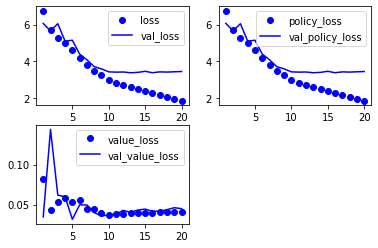

In [36]:
plotHistory(history)


##### Just ignore

In [119]:
model.load_weights('models/model-01.hdf5')

In [120]:
model.evaluate(x_val,[values_val],verbose=True)

10000/10000 [==============================] - 5s 509us/step


[0.8222289905548096, 0.0001]